## 準備

In [32]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

In [5]:
df = pd.read_csv(os.path.join(os.getcwd(),'data','temperature.csv'), encoding='shift-jis', skiprows=3)
df.columns = ['datetime', 'temp']
df['datetime'] = pd.to_datetime(df['datetime'])

print(df.shape)
print(df['datetime'].min(), '\n-->', df['datetime'].max())
df.head()

(8784, 2)
2022-11-26 01:00:00 
--> 2023-11-27 00:00:00


,datetime,temp
0,2022-11-26 01:00:00,10.9
1,2022-11-26 02:00:00,10.9
2,2022-11-26 03:00:00,10.7
3,2022-11-26 04:00:00,10.7
4,2022-11-26 05:00:00,10.6


mean: 17.36240892531876, std: 9.45575690557394


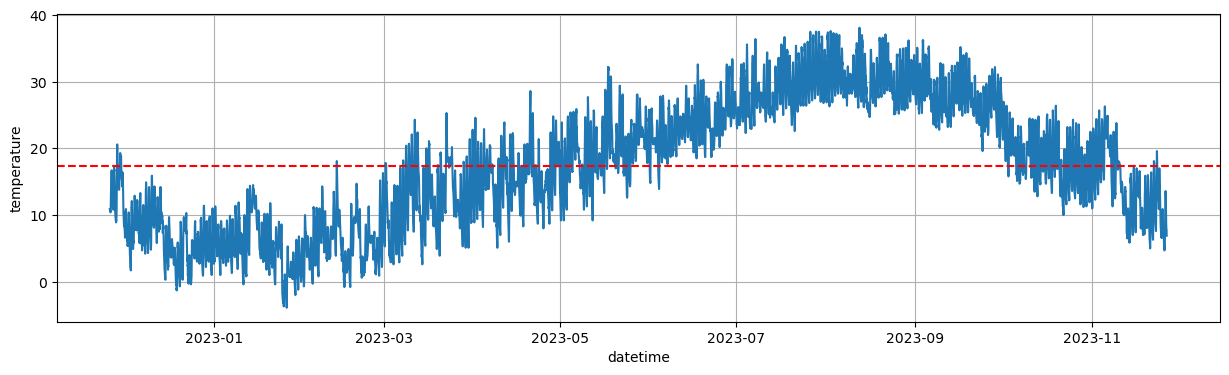

In [6]:
# 1時間ごと気温(生データ)
print(f'mean: {df.temp.mean()}, std: {df.temp.std()}')
plt.figure(figsize=(15,4))
plt.plot(df['datetime'], df['temp'])
plt.xlabel('datetime')
plt.ylabel('temperature')
plt.axhline(y=df.temp.mean(), color='red', linestyle='--')
plt.grid()
plt.show()

## 自己相関係数

In [67]:
MAX_LAG = 100

df_lag = df[['temp']].copy()
for lag in range(1, MAX_LAG+1):
    df_lag[f'lag{lag}'] = df_lag.temp.shift(lag)
df_lag = df_lag.dropna()

corr = df_lag.corr()
corr = corr.loc[['temp'], :]

C:\Users\takumi\AppData\Local\Temp\ipykernel_17156\835352107.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_lag[f'lag{lag}'] = df_lag.temp.shift(lag)


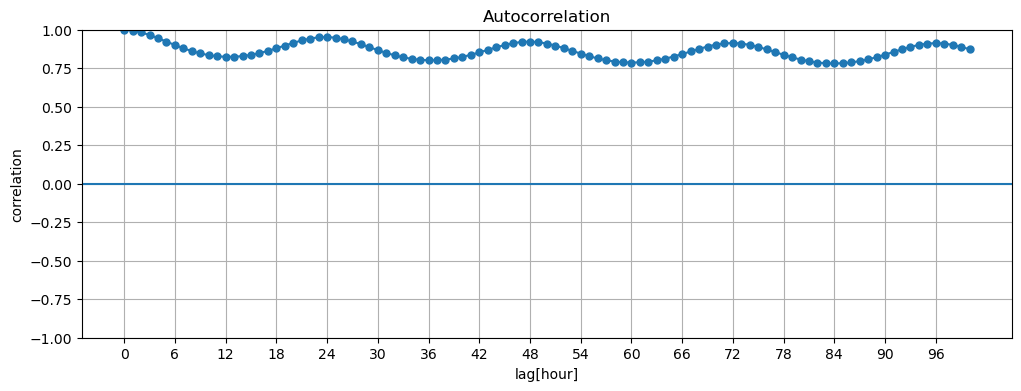

In [8]:
plt.figure(figsize=(12,4))
plt.plot(corr.values[0], marker='o', markersize=5)
plt.xlabel('lag[hour]')
plt.ylabel('correlation')
plt.xticks(range(0, MAX_LAG+1, 6))
plt.axhline(y=0)
plt.ylim(-1, 1)
plt.title('Autocorrelation')
plt.grid()
plt.show()

## 偏自己相関係数

In [42]:
MAX_LAG = 100

df_lag = df[['temp']].copy()
for lag in range(1, MAX_LAG+1):
    df_lag[f'lag{lag}'] = df_lag.temp.shift(lag)
df_lag = df_lag.dropna()

pacf_values = [1., df_lag.corr()['temp']['lag1']]
for lag in range(2, MAX_LAG+1):
    # t-1,t-2,...,t-lag+1からtを予測する
    lr_forward = LinearRegression()
    lr_forward.fit(df_lag[[f'lag{i}' for i in range(1, lag)]], df_lag['temp'])

    # t-1,t-2,...,t-lag+1からt-2を予測する
    lr_backward = LinearRegression()
    lr_backward.fit(df_lag[[f'lag{i}' for i in range(1, lag)]], df_lag[f'lag{lag}'])

    # lr_forwardの残差とlr_backwardの残差の相関を求める
    residual = pd.DataFrame()
    residual['residual1'] = df_lag['temp'] - lr_forward.predict(df_lag[[f'lag{i}' for i in range(1, lag)]])
    residual['residual2'] = df_lag[f'lag{lag}'] - lr_backward.predict(df_lag[[f'lag{i}' for i in range(1, lag)]])

    # 結果をリストへ格納
    pacf_values.append(residual.corr()['residual1']['residual2'])

C:\Users\takumi\AppData\Local\Temp\ipykernel_17156\1690341618.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_lag[f'lag{lag}'] = df_lag.temp.shift(lag)


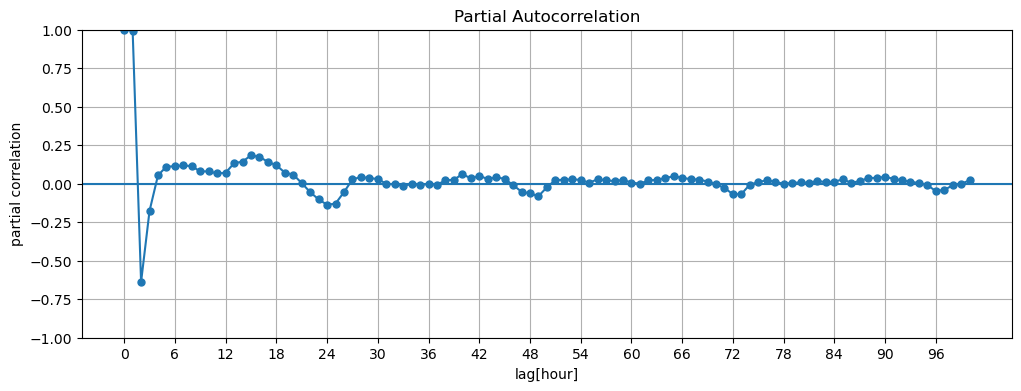

In [46]:
plt.figure(figsize=(12,4))
plt.plot(pacf_values, marker='o', markersize=5)
plt.xlabel('lag[hour]')
plt.ylabel('partial correlation')
plt.xticks(range(0, MAX_LAG+1, 6))
plt.axhline(y=0)
plt.ylim(-1, 1)
plt.title('Partial Autocorrelation')
plt.grid()
plt.show()

## statsmodelsの場合

In [36]:
# ライブラリで自己相関係数，偏自己相関係数を求める（値のみ）
from statsmodels.tsa.stattools import pacf, acf

pacf_values = pacf(df['temp'], nlags=MAX_LAG)
acf_values = acf(df['temp'], nlags=MAX_LAG)

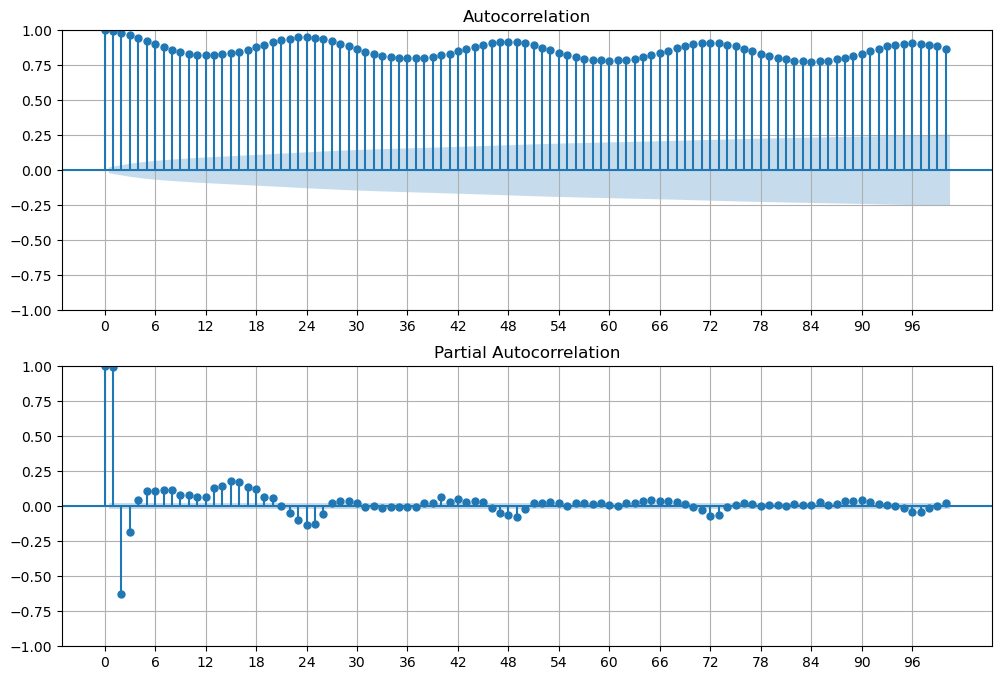

In [45]:
# ライブラリで自己相関係数，偏自己相関係数を求める（グラフ付き）
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
plot_acf(df['temp'], lags=MAX_LAG, ax=ax1)
plt.xticks(range(0, MAX_LAG+1, 6))
plt.grid()

ax2 = fig.add_subplot(212)
plot_pacf(df['temp'], lags=MAX_LAG, ax=ax2)
plt.xticks(range(0, MAX_LAG+1, 6))
plt.grid()
plt.show()
